# Exploratory Data Analysis and NLP on the collected job ads
#### Analysis on the job ads
In this notebook I am analysing the stored job ads, with the goal of gathering interesting insights.

In [1]:
import json
import string
import spacy
from spacy.lang.en import English
import numpy as np
import pandas as pd
from matplotlib import rc, pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from fastai.text import TextList
import seaborn as sns
from collections import Counter
import plotly.express as px
import re

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk import stem

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raffaele\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Raffaele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
# Read JSON file
#december file : 'data/job_ads_container_dec20.json'
#october file : 'data/job_ads_container_large.json'
#july file: 'data/job_ads_container_large_july2020.json'

with open('data/job_ads_container_large_july2020.json') as data_file:
    job_ads_container = json.load(data_file)

In [4]:
number_of_job_ads = len(job_ads_container)

## Text Lemmatization, Stemming and Vectorising with nlkt and sk-learn

In [93]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()
nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation
parser = English()

In [84]:
description_text = [job_ads_container[item]['Description'] for item in job_ads_container]

In [43]:
description_text[0]

' Data Scientist £43,860-£52,866 + benefits Location: Hounslow, but currently remote We’re more than digital. We’re improving lives.  To give residents life-improving digital services, we need to make the most of our data. As a Data Scientist, you’ll hold the key – and be the catalyst for data innovation. This is a great opportunity to maximise our information assets using emerging and established technologies. Leading data science across the council, you’ll ensure that data is used to optimise services and solve complex business issues. It means investigating  information sources and looking for areas where data science can improve the way we work. You’ll also build models and dashboards that calculate current and future service demand. Day to day you’ll be collecting, aggregating and migrating data, working closely with colleagues throughout the organisation as well as within Digital and IT. You’ll therefore need experience in a similar role, delivering data solutions that are resili

In [94]:
description_text_words = [nltk.word_tokenize(text) for text in description_text]

In [95]:
# splitting each text in words to perform lemmatization and stemming
description_text_lem = [[wnl.lemmatize(word) for word in text] for text in description_text_words]
description_text_stem = [[porter.stem(word) for word in text] for text in description_text_words]

### Introducing SpaCy to lemmatize (rather than stem) the ads text, and detect occurrencies of R

In [96]:
#Lemmatization using spacy
def spacy_tokenizer(sentence):
    sentence=re.sub(r'\sR(?=\W?\s?)(?!\w)',' Rlanguage ',sentence)
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] # corrected stopwords
    # return preprocessed list of tokens
    return mytokens

description_text_lem_spacy = [spacy_tokenizer(text) for text in description_text]

In [97]:
# Re-joining the lists into a text
separator = ' '
descriptions_lem = [separator.join(text) for text in description_text_lem]
descriptions_stem = [separator.join(text) for text in description_text_stem]
descriptions_lem_spacy = [separator.join(text) for text in description_text_lem_spacy]

### Examples with Stemming and Lemmatisation
### _Original text_

In [55]:
description_text[0][20:130]

'Spoken Language Understanding team is looking for a senior data scientist to join a recently established team in London.'

### _Stemmed text_

In [62]:
descriptions_stem[0][20:130]

'spoken languag understand team is look for a senior data scientist to join a recent establish team in london .'

### _Lemmatized text_

In [81]:
basic_sentence=description_text[0][28:148]
lemmatized_sentence=[wnl.lemmatize(word, pos = 'v') for word in basic_sentence.split()]
separator.join(lemmatized_sentence)

'Spoken Language Understanding team be look for a senior data scientist to join a recently establish team in London.'

In [77]:
print("spoken :", wnl.lemmatize("spoken", pos = 'v')) 
print("corpora :", wnl.lemmatize("corpora")) 

# a denotes adjective in "pos" 
print("better :", lemmatizer.lemmatize("better", pos ="a")) 

spoken : speak
corpora : corpus
better : good


### Vectorisation
We now proceed in creating the words vocabulary, and vectorising the corpus of job ads.

In [98]:
vectorizer = TfidfVectorizer(input='content', stop_words='english')
dtm = vectorizer.fit_transform(descriptions_lem_spacy).toarray()
vocab = np.array(vectorizer.get_feature_names())
dtm.shape, len(vocab)

((241, 5110), 5110)

In [90]:
type(vocab)

numpy.ndarray

Let's take a look at a random word in my vocabulary

In [78]:
vocab[5220]

'stakeholder'

In [54]:
'rlanguage' in vocab

True

In [17]:
dtm

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.12535323, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06642016],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Saving description and vectorised content

In [99]:
np.save('data/dtm_jul20.npy',dtm)
np.save('data/vocab_jul20.npy',vocab)

## Most relevant key words

By summing the weights of each word across the job ads, we can obtain a scoring system, that highlights the most important key words. By browsing them, we can see that many of the highest scoring words are omnipresent and not particularly significant (_data, work, this, experience_...). We can however isolate some skills that we are more interested in, put them into a list, and use it to filter the words score dataframe, and obtain the score of those key skills.



In [12]:
scores = {'Words': vocab,'Scores':sum(dtm)}
word_scores = pd.DataFrame(data = scores)
word_scores.sort_values(by = ['Scores'],inplace = True, ascending = False)

In [20]:
word_scores[0:20]

,Words,Scores
1468,data,32.374955
6004,work,19.932242
1505,datum,18.272121
2102,experience,18.228184
3253,machine,14.852742
5465,team,14.835059
3103,learning,14.621229
4852,science,14.604153
4862,scientist,14.176216
1922,engineer,12.895656


In [23]:
key_skills = ['python', 'rlanguage',
             'experience','junior','senior',
             'sql',
             'nlp','language',
             'marketing', 'customer','market',
              'estate',
              'product','research','analytics','analyt',
             'statistics','modelling',
             'recommender',
             'financial','fintech',   
             'opencv','vision',
             'social',
             'java','c++',
             'deep','neural',
              'machine',
              'aws'
             ]

In [24]:
word_scores[word_scores.Words.isin(key_skills)]

,Words,Scores
2102,experience,18.228184
3253,machine,14.852742
4229,product,11.073862
4368,python,10.402252
1438,customer,10.020297
4937,senior,8.637919
4626,research,8.566452
5199,sql,6.957255
3662,nlp,6.155183
632,aws,5.843109


In [25]:
key_skills_few = ['python','rlanguage','java',
             'experience','senior','junior',
             'sql',
             'nlp','marketing',
             'product','research','analytics','customer',
             'model',
             'recommend','fintech','financ',   
             'vision',
             'social',
             'java','c++',
             'deep',
              'machine',
              'aws'
             ]

In [27]:
word_scores[word_scores.Words.isin(key_skills_few)]

,Words,Scores
2102,experience,18.228184
3253,machine,14.852742
4229,product,11.073862
4368,python,10.402252
3483,model,10.094220
1438,customer,10.020297
4937,senior,8.637919
4626,research,8.566452
5199,sql,6.957255
3662,nlp,6.155183


### _Based on the analysis, what are the most recurring key words in data science job ads?_  
### (_December 2020_)
Similar results to July. It is interesting to note the relative importance among programming languages (python, R, SQL, java), and AI tools and techniques.

### (_July 2020_)
 - **Experience**
 - **Product, Market**
 - **Modelling, Statistics**
 - **Python**
 - **SQL**
 - **NLP**
 - **AWS**
 - **Senior** rather than **Junior**
 - **Research, Insight, Analytics**
 - **Deep Learning**
 - **FinTech**

Computer vision is less present, along with social media and java.

## Comparing the advertised salary and contract type to the presence of keywords in the job description

I am going to restrict the analysis to the words contained in _key_skills_, as I don't want highly recurring words, such as "data science" and "work", to skew my analysis. This is obviously a personal choice and a very valid alternative approach would be to consider the 50 (or more) most common words, and to extend the analysis to more job ads. Unfortunately the market now (i.e. July 2020) sucks, and there aren't that many advertised positions online. The scraping notebook may be extended to include other job boards, which might provide a more well-rounded picture of the job market. another thing that could be done is to compare the scraped job descriptions, to make sure that there are no repetitions, e.g. same job advertised by multiple recruitment agencies.

In [28]:
features_indexes = word_scores[word_scores.Words.isin(key_skills_few)].index

In [29]:
features_indexes

Int64Index([2102, 3253, 4229, 4368, 3483, 1438, 4937, 4626, 5199, 3662,  632,
            4725, 3315,  415, 1543, 5901, 2243, 2954, 5099, 3000, 4486],
           dtype='int64')

In [30]:
factors_matrix = dtm[:,features_indexes]

In [31]:
factors_matrix[:,5] # to see what it's like

array([0.        , 0.04933041, 0.21978289, 0.04121076, 0.04453728,
       0.        , 0.26094861, 0.02783927, 0.02857128, 0.        ,
       0.        , 0.        , 0.        , 0.23376792, 0.        ,
       0.        , 0.        , 0.1255956 , 0.        , 0.        ,
       0.        , 0.12588018, 0.22718259, 0.29207881, 0.        ,
       0.04965269, 0.        , 0.        , 0.        , 0.44780152,
       0.        , 0.        , 0.1255956 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0359348 , 0.05655034, 0.        ,
       0.05561217, 0.        , 0.23108745, 0.        , 0.        ,
       0.03225009, 0.12405605, 0.        , 0.05433586, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18344035,
       0.        , 0.        , 0.36439028, 0.        , 0.05914773,
       0.        , 0.        , 0.07599484, 0.        , 0.07991

So we have a few hundreds observations (i.e. jobs) with a manageable number of features (i.e. key skills). Now I need to add the salary information.

## Testing salary value extraction

In [33]:
# Extracting test value
salary_field=job_ads_container[list(job_ads_container.keys())[45]]['Salary'].split()

from statistics import mean

def salary_extractor(test_list):
    '''
    This function takes the salary field within each job's scraped data and extracts an average value for the proposed salary, adjusted per annum
    '''
    extremes = []
    av_salary = None
    salary = None
    for item in test_list:
        if item[0]=='£':
            extremes.append(float(item[1:].replace(',', '')))
    if extremes:
        av_salary = mean(extremes)
    
        if 'day' in test_list or 'Day' in test_list:
            salary = av_salary* 260
        elif 'annum' in test_list or 'annum' in test_list:
            salary=av_salary
        else:
            salary=av_salary
    
    return salary

print('Printing test value')            
print(salary_extractor(salary_field))

Printing test value
65000.0


In [35]:
job_salary_df = pd.DataFrame(columns = ['Job_id','Salary'])
job_ids = []
job_salaries = []
for item in job_ads_container:
    job_ids.append(item)
    try:
        salary_field=job_ads_container[str(item)]['Salary'].split()
        salary = salary_extractor(salary_field)
        
    except AttributeError:
        salary = None

    job_salaries.append(salary)

job_salary_df.Job_id = job_ids
job_salary_df.Salary = job_salaries

# Here I build a dataframe with:
#     Job_id
#     Salary - as calculated in the salary_extractor function
#     python...neural - key skill words with values for each observation


In [36]:
for i in features_indexes:
    job_salary_df[vocab[i]] = dtm[:,i]

In [37]:
job_salary_df.to_csv('data/job_salary_df_dec20.csv')
job_salary_df.head()

,Job_id,Salary,experience,machine,product,python,model,customer,senior,research,...,rlanguage,marketing,analytics,deep,vision,fintech,java,social,junior,recommend
0,41499627,NaN,0.022712,0.000000,0.0,0.000000,0.039011,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,41413487,45000.0,0.092630,0.167191,0.0,0.068842,0.079554,0.049330,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.071616,0.0,0.0,0.0,0.0,0.0
2,41264741,72500.0,0.144444,0.111733,0.0,0.061343,0.035444,0.219783,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,41301184,143000.0,0.193459,0.069836,0.0,0.086266,0.232610,0.041211,0.0,0.0,...,0.000000,0.0,0.0,0.047926,0.000000,0.0,0.0,0.0,0.0,0.0
4,41264408,77500.0,0.041815,0.301891,0.0,0.062153,0.035912,0.044537,0.0,0.0,...,0.047461,0.0,0.0,0.103590,0.000000,0.0,0.0,0.0,0.0,0.0


### Fraction of missing values in Salary
Was 24% on September, roughly 50% in July.

In [38]:
job_salary_df['Salary'].isnull().sum()/len(job_salary_df['Salary'])

0.21005917159763313

### Salary against key words correlation heatmap

In [39]:
corr = job_salary_df.drop(['Job_id'],axis=1).corr()

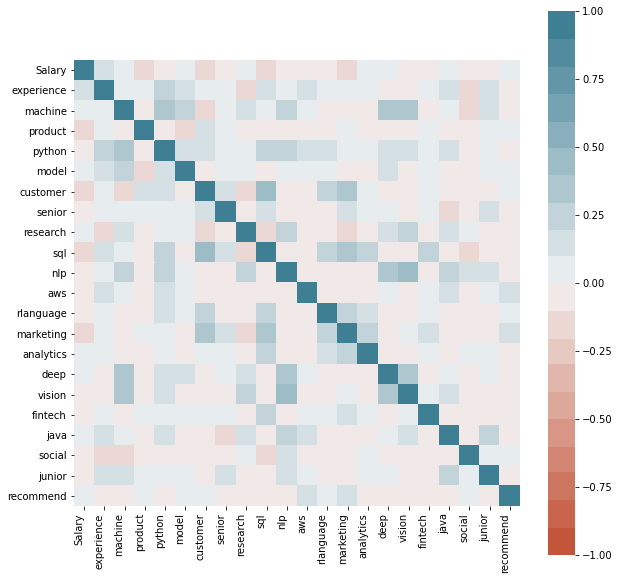

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    #cmap = sns.color_palette("RdBu_r",7),
    cmap=sns.diverging_palette(20, 220, n=20),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

plt.savefig('data/corr_heatmap_v3.png')

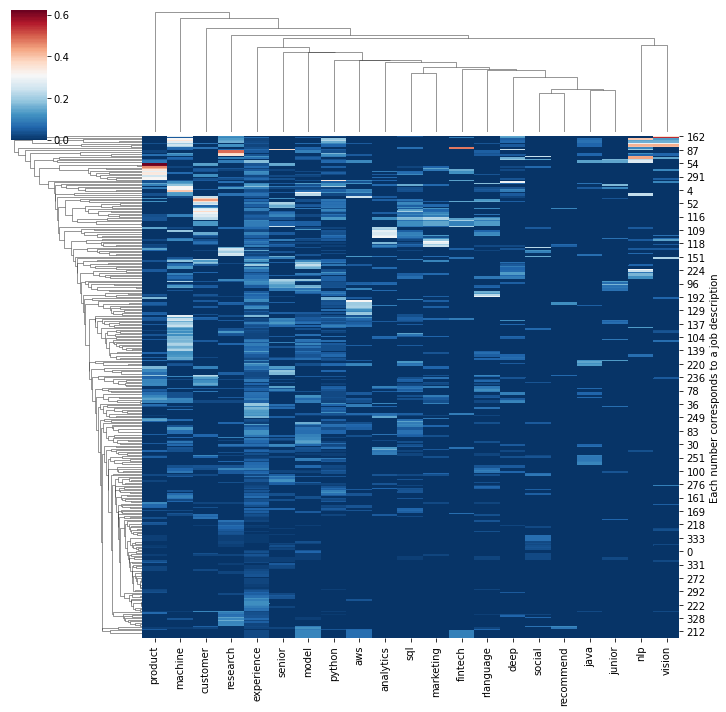

In [41]:
#cmap = sns.color_palette("RdBu_r",7)
skills_map = job_salary_df.drop(['Job_id','Salary'],axis=1)

sns.set_palette("husl")
g = sns.clustermap(skills_map,cmap = sns.color_palette("RdBu_r",100))
g.ax_heatmap.set_ylabel('Each number corresponds to a job description')
plt.savefig('data/cluster_heatmap.png')

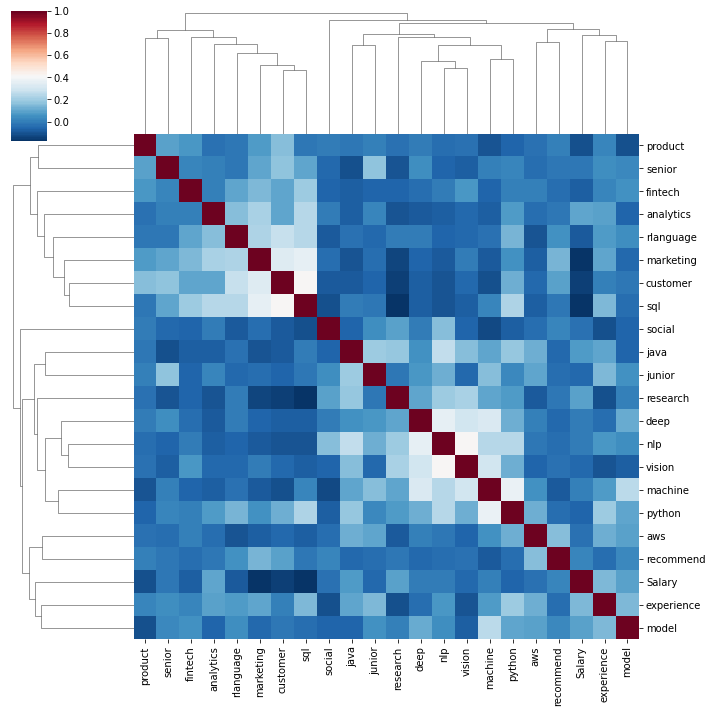

In [42]:
sns.set_palette("husl")
g = sns.clustermap(corr,cmap = sns.color_palette("RdBu_r",100))
plt.savefig('data/corr_cluster_heatmap_dec20.png')

_July_: Unfortunately 69% of the values are missing, which makes the analysis less valuable.

_October_ : 25% of values are missing.

### _Based on this analysis, what are the clearest correlations present in the dataset?_

## Trends in job ads
Analysis based on the frequency of appearance of key words.
### Permanent or Contract
When unspecified, I am inclined to think it's a permanent job.

In [43]:
p = 0 # permanent
c = 0 # contract
total = 0
for item in job_ads_container:
    total+=1
    if job_ads_container[item]['Contract']:
        if 'Permanent' in job_ads_container[item]['Contract']:
            p+=1
        elif 'Contract' in job_ads_container[item]['Contract']:
            c+=1
    elif job_ads_container[item]['Salary']:
        if 'annum' in job_ads_container[item]['Salary']:
            p+=1
        elif 'day' in job_ads_container[item]['Salary']:
            c+=1
        
print('permanent = ',p,'; contract = ',c,'; total = ',total)

permanent =  276 ; contract =  60 ; total =  338


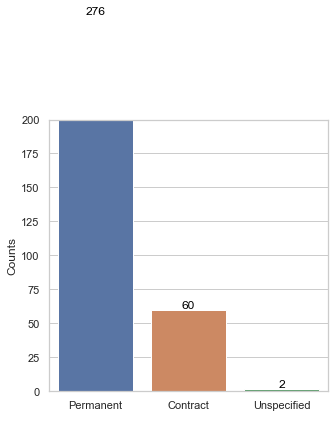

In [44]:
sns.set(style="whitegrid")
data=pd.DataFrame(columns=["Contract","Counts"])
spec = ['Permanent','Contract','Unspecified']
counts = [p,c,total-p-c]
data.Contract= spec
data.Counts = counts

plt.figure(figsize=(5,5))
ax = sns.barplot(x='Contract', y="Counts", data=data)
ax.set_xlabel(' ')
ax.set_ylim(0,200)

x_in=0
for index, row in data.iterrows():
    ax.text(x_in,row.Counts+1, row.Counts, color='black', ha="center")
    x_in+=1
plt.savefig('data/contract_barplot_dec20.png')

### Senior or...not

In [45]:
s =0
total = 0
for desc in descriptions_stem:
    if 'senior' in desc:
        s+=1
    total+=1
print('Senior = ',s,'; total = ',total)

Senior =  123 ; total =  338


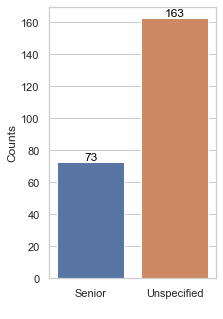

In [56]:
sns.set(style="whitegrid")
data=pd.DataFrame(columns=["Senior","Counts"])
spec = ['Senior','Unspecified']
counts = [s,total-s]
data.Senior= spec
data.Counts = counts

plt.figure(figsize=(3,5))
ax = sns.barplot(x='Senior', y="Counts", data=data)
ax.set_xlabel(' ')
ax.set_ylim(0,170)

x_in=0
for index, row in data.iterrows():
    ax.text(x_in,row.Counts+1, row.Counts, color='black', ha="center")
    x_in+=1
plt.savefig('data/senior_barplot.png')

### Mentions of popular skills

In [54]:
check = 0
total=0
skills_dict = {'python':0, 'sql':0,'rlanguage':0,'nlp':0,'deep':0}
for desc in descriptions_lem_spacy:
    total+=1
    if any(skill in desc for skill in skills_dict) == False:
        check+=1
    else:
        for skill in skills_dict:
            if skill in desc:
                skills_dict[skill]+=1
 
skills_dict['None of these'] = check
skills_dict['Total'] = total

print(skills_dict)

{'python': 195, 'sql': 118, 'rlanguage': 79, 'nlp': 33, 'deep': 70, 'None of these': 99, 'Total': 338}


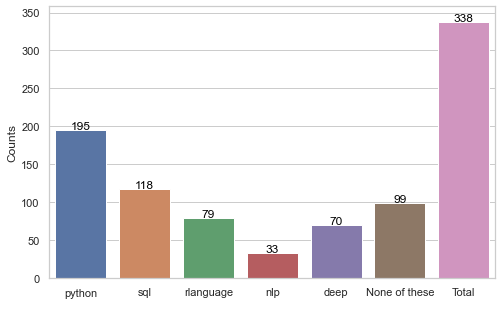

In [63]:
sns.set(style="whitegrid")
data=pd.DataFrame(columns=["Skills","Counts"])
data.Skills= list(skills_dict.keys())
data.Counts = list(skills_dict.values())

plt.figure(figsize=(8,5))
ax = sns.barplot(x='Skills', y="Counts", data=data)
ax.set_xlabel(' ')
ax.set_ylim(0,max(data.Counts)+20)

x_in=0
for index, row in data.iterrows():
    ax.text(x_in,row.Counts+1, row.Counts, color='black', ha="center")
    x_in+=1
plt.savefig('data/skills_barplot_dec20.png')

## Analysis of job posters

In [65]:
posters = [job_ads_container[item]['ad_poster'] for item in job_ads_container]
ad_posters_df = pd.DataFrame(data=posters, columns= ['ad_poster'])
ad_posters_df['Count']=1
ad_posters_df=ad_posters_df.groupby(by='ad_poster').sum().sort_values(by='Count',ascending=False)

In [66]:
ad_posters_short = ad_posters_df[ad_posters_df.Count>=5]
ad_posters_summary = ad_posters_short.copy()
ad_posters_summary.at['Other/Missing','Count']=int(number_of_job_ads - ad_posters_short.Count.sum())

In [67]:
ad_posters_summary

,Count
ad_poster,
Harnham,98.0
Partnership Jobs,34.0
NHS Business Services Authority,23.0
Jefferson Frank,14.0
X4 Group,10.0
Understanding Recruitment,10.0
Blue Pelican,6.0
ADLIB,5.0
Other/Missing,138.0


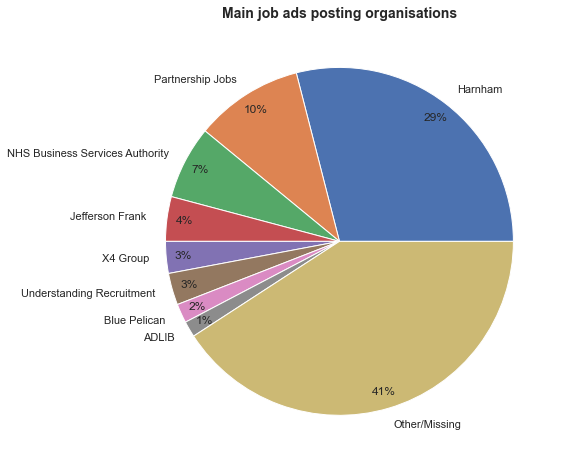

In [68]:
ad_posters_summary.plot(y='Count',kind='pie',figsize=(8, 8),ylabel='',autopct='%1.0f%%',pctdistance=0.9,legend = False)
plt.title('Main job ads posting organisations', weight='bold', size=14)
plt.savefig('data/Main_job_ads_posting_organisations.png')

By looking at the names of the job ads posters in the pie chart, you can guess that most of them are recruitment consultanting firms. The information on the kind of job poster is contained in the job ad pages, in a javascript hash table. I have extracted the corresponding information by filtering the scraped text with a regular expression.

In [69]:
poster_types = [job_ads_container[item]['ad_poster_type'] for item in job_ads_container]
poster_types_df = pd.DataFrame(data=poster_types, columns= ['ad_poster_type'])
poster_types_df['Count']=1
poster_types_df=poster_types_df.groupby(by='ad_poster_type').sum().sort_values(by='Count',ascending=False)

In [70]:
poster_types_df

,Count
ad_poster_type,
Recruitment consultancy,262
Direct employer,76


In [71]:
job_Knowledge_Domain_types = [job_ads_container[item]['job_Knowledge_Domain'] for item in job_ads_container]
job_Knowledge_Domain_types_df = pd.DataFrame(data=job_Knowledge_Domain_types, columns= ['job_Knowledge_Domain'])
job_Knowledge_Domain_types_df['Count']=1
job_Knowledge_Domain_types_df=job_Knowledge_Domain_types_df.groupby(by='job_Knowledge_Domain').sum().sort_values(by='Count',ascending=False)
job_Knowledge_Domain_types_df

,Count
job_Knowledge_Domain,
Information Technology,218
Marketing And Media,50
Health And Social,22
Financial Services,19
Engineering,11
Sales,7
Legal,3
Logistics And Transport,2
Security And Safety,2


In [72]:
job_Knowledge_Domain_types_short = job_Knowledge_Domain_types_df[job_Knowledge_Domain_types_df.Count>=5]
job_Knowledge_Domain_types_summary = job_Knowledge_Domain_types_short.copy()
job_Knowledge_Domain_types_summary.at['Other/Missing','Count']=int(number_of_job_ads - job_Knowledge_Domain_types_short.Count.sum())

In [73]:
job_Knowledge_Domain_types_summary

,Count
job_Knowledge_Domain,
Information Technology,218.0
Marketing And Media,50.0
Health And Social,22.0
Financial Services,19.0
Engineering,11.0
Sales,7.0
Other/Missing,11.0


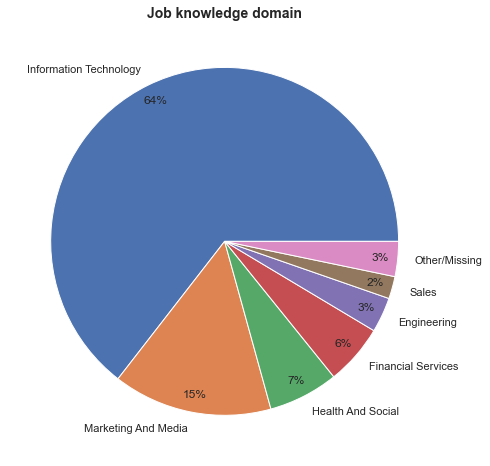

In [74]:
job_Knowledge_Domain_types_summary.plot(y='Count',kind='pie',figsize=(8, 8),ylabel='',autopct='%1.0f%%',pctdistance=0.9,legend = False)
plt.title('Job knowledge domain', weight='bold', size=14)
plt.savefig('data/job_knowledge_domain.png')

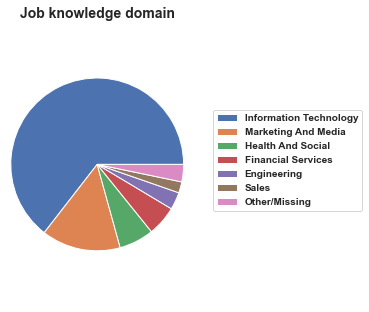

In [75]:
font = {'family' : 'arial', 'weight': 'bold', 'size': 10}
rc('font', **font); rc("figure", facecolor="white"); rc('axes', edgecolor='darkgray')

#pie = job_Knowledge_Domain_types_df.plot(y='Count',kind='pie',figsize=(8, 8),ylabel='',autopct='%1.0f%%',pctdistance=0.9,labels=None,legend = True)

plt.gca().axis("equal")
pie = plt.pie(job_Knowledge_Domain_types_summary['Count'], startangle=0, pctdistance=0.9, radius=1.2)
labels=job_Knowledge_Domain_types_summary.index.unique()

plt.title('Job knowledge domain', weight='bold', size=14)
fig = plt.gcf()
fig.set_size_inches(5,5)

plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.1, right=0.5)

plt.savefig('data/job_knowledge_domain_legend_dec20.png')

## WordCloud

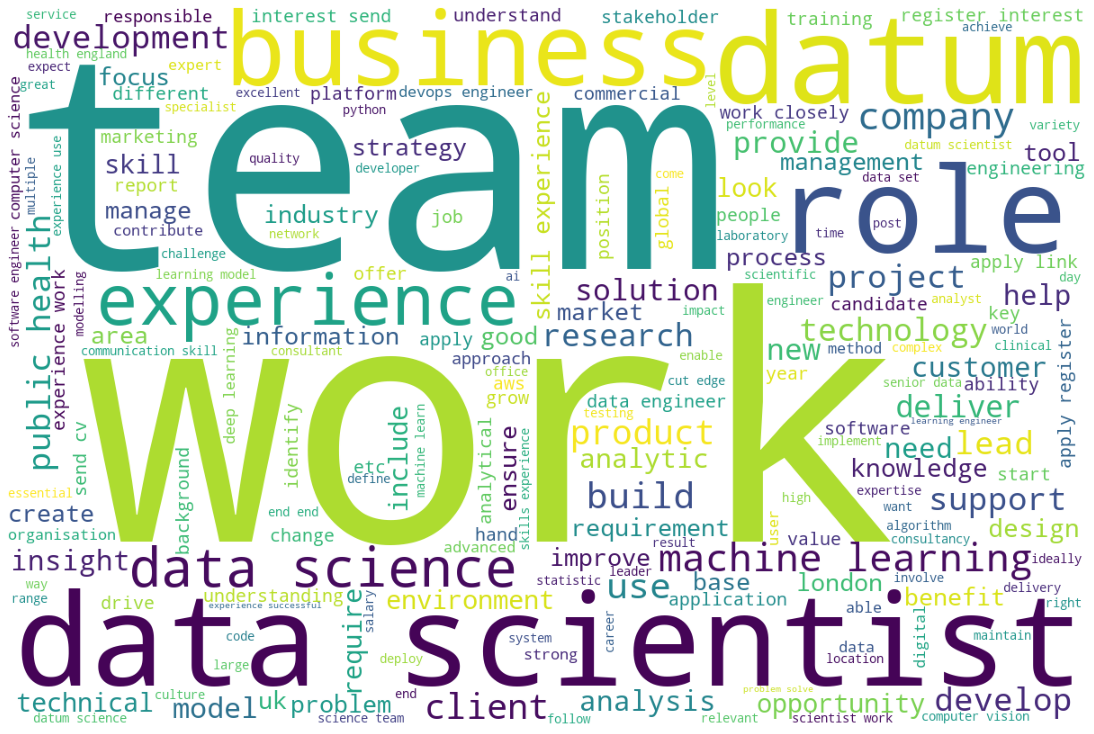

In [77]:
from wordcloud import WordCloud, STOPWORDS

text = ''
for desc in descriptions_lem_spacy:
    text+=desc

stopwords = set(STOPWORDS)

additional_stopwords = ['You will ','will be','be','will','You','within']
for sw in  additional_stopwords:
    stopwords.add(sw)
# Generate a word cloud image

# Display the generated image:
# the matplotlib way:
wordcloud=WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(text) 

# lower max_font_size
#wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize = (16, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 

plt.tight_layout(pad = 0) 
  
plt.savefig('data/white_wordcloud_dec20.png')
plt.show()